# 4. Internal Linear Combination (ILC) applied to wavelet coefficient maps across all frequency channels at each scale

In [1]:
import math
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import matplotlib.pyplot as plt
import torch
import time
from s2fft.transforms import spherical as s2sh
%matplotlib inline 

/home/matthew/ENTER/envs/skyclean‐fix/lib/python3.13/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.6.2 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


### 4.1 Create the directory structure to store data

In [5]:

def check_and_create_ilc_directories():
    """
    Checks for the existence of a specific nested directory structure for ILC processing and creates any missing directories.
    This includes handling multiple levels of nested directories as shown in the provided folder structure.

    The structure checked is:
    - ILC
      - covariance_matrix
      - ILC_doubled_maps
      - ILC_processed_wavelet_maps
      - synthesized_ILC_MW_maps
      - wavelet_doubled
      - weight_vector_data
    """

    # Define the root directories
    # base_dir = "path_to_base_directory"  # Set this to your base directory path
    # ilc_dir = os.path.join(base_dir, "ILC")
    ilc_dir = "data/ILC"
    # List of directories under the ILC directory
    ilc_sub_dirs = ["covariance_matrix", "ILC_doubled_maps", "ILC_processed_wavelet_maps", "synthesized_ILC_MW_maps","wavelet_doubled","weight_vector_data"]

    # Create the ILC directory and its subdirectories
    create_directory(ilc_dir)
    for sub_dir in ilc_sub_dirs:
        create_directory(os.path.join(ilc_dir, sub_dir))

def create_directory(dir_path):
    """
    Checks if a directory exists, and if not, creates it. Prints the status of the directory.
    
    Parameters:
        dir_path (str): The path of the directory to check and create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

# Run the function to check and create directories as needed
check_and_create_ilc_directories()


Directory already exists: data/ILC
Directory already exists: data/ILC/covariance_matrix
Directory already exists: data/ILC/ILC_doubled_maps
Directory already exists: data/ILC/ILC_processed_wavelet_maps
Directory already exists: data/ILC/synthesized_ILC_MW_maps
Directory already exists: data/ILC/wavelet_doubled
Directory already exists: data/ILC/weight_vector_data


### 4.2 ILC Functions 

In [ ]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''
    Converts MW alm coefficients to HEALPix alm coefficients.
    
    Arg:
        MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
        lmax: maximum multipole moment of the MW alm
    Returns:
        hp_alm: 1D array in healpix 
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm

def visualize_wavelet_coefficient_map(MW_Pix_Map, title, variable,
                                     vmin=None, vmax=None,
                                     use_torch=True):
    """
    Processes a wavelet coefficient map and visualizes it using HEALPix mollview,
    with optional PyTorch acceleration for the forward transform.

    Args:
        MW_Pix_Map (ndarray): the MW wavelet coefficient map (sampling="mw").
        title (str): title prefix for the plot.
        variable (str): variable name to append in title.
        vmin, vmax (float, optional): color-map limits.
        use_torch (bool): if True, use s2sh.forward_torch; else s2fft.forward.

    Returns:
        original_hp_map (ndarray): the HEALPix map that was plotted.
    """
    log = open("timing_log.txt", "a", buffering=1)
    # determine L_max
    if MW_Pix_Map.shape[0] != 1:
        L_max = MW_Pix_Map.shape[0]
    else:
        L_max = MW_Pix_Map.shape[1]
    arr = MW_Pix_Map.copy()  
    # 1) forward to MW alm
    if use_torch:
        torch.cuda.empty_cache()
        with torch.no_grad():
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            x = torch.tensor(arr, dtype=torch.float32, device=device)

            t0 = time.perf_counter()
            mw_alm = s2sh.forward_torch(x, L=L_max, sampling="mw")
            elapsed = time.perf_counter() - t0
            print(f"s2sh.forward_torch time: {elapsed:.3f}s")

            mw_alm = mw_alm.cpu().numpy()
    else:
        t0 = time.perf_counter()
        mw_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        elapsed = time.perf_counter() - t0
        print(f"s2fft.forward time: {elapsed:.3f}s")

    # 2) convert MW alm to HEALPix alm
    hp_alm = mw_alm_2_hp_alm(mw_alm, L_max - 1)

    # 3) synthesize HEALPix map
    nside = (L_max - 1) // 2
    original_hp_map = hp.alm2map(hp_alm, nside=nside)

    # 4) plot
    hp.mollview(
        original_hp_map,
        coord=["G"],
        title=f"{title} {variable}",
        unit="K",
        min=vmin,
        max=vmax,
    )
    plt.show()

    return original_hp_map

def Single_Map_doubleworker(MW_Pix_Map, use_torch = True):
    '''
    Arg:
        MW_Pix_Map: a MW wavelet coefficent pixel map of shape (1, Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
        It is the output of s2wav.analysis
        (Scale: 0, size (1, 4, 7))

    Process:
        1. Covert MW Pixel Map to MW alm space using s2fft.forward

        2. Double alm: Add zero to the mw alms  
        
        3. Convert doubled mw alm to mw map 

    Returns:
        MW_Pix_Map_doubled: The MW pixel map with increased resolution.
    
    '''
    log = open("timing_log.txt", "a", buffering=1)
    torch.cuda.empty_cache()
    if use_torch:
        with torch.no_grad():
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            x = torch.tensor(MW_Pix_Map, dtype=torch.float32, device=device)
            # forward
            t0 = time.perf_counter()
            alm = s2sh.forward_torch(x, L=x.shape[1], sampling="mw")
            alm = alm.cpu() #move to cpu for padding
            del x
            torch.cuda.empty_cache()
            log.write(f"s2fft forward_torch time (doubling): {time.perf_counter()-t0:.2f}s\n")

            L = alm.shape[0]
            # pad in alm‐space
            H = 2*L-1
            W = 2*H - 1
            padded = torch.zeros((H, W), dtype=alm.dtype)
            mid_in = alm.shape[1]//2
            mid_out = W//2
            start = mid_out - mid_in
            padded[:L, start:start+alm.shape[1]] = alm
            padded = padded.to(device)
            del alm
            torch.cuda.empty_cache()
            # inverse
            t0 = time.perf_counter()
            x2 = torch.real(s2sh.inverse_torch(padded, L=H, sampling="mw"))
            del padded
            torch.cuda.empty_cache()
            log.write(f"s2fft inverse_torch time (doubling): {time.perf_counter()-t0:.2f}s\n")  
            # back to np on CPU
            
            return x2.cpu().numpy()

    else:
        # use jax/numpy
        t0 = time.perf_counter()
        alm = s2fft.forward(MW_Pix_Map, L=MW_Pix_Map.shape[1])
        log.write(f"s2fft forward time (doubling): {time.perf_counter()-t0:.2f}s\n")

        L = alm.shape[0]
        H = 2*L - 1
        W = 2*H - 1
        padded = np.zeros((H, W), dtype=np.complex128)
        mid_in = alm.shape[1]//2
        mid_out = W//2
        start = mid_out - mid_in
        padded[:L, start:start+alm.shape[1]] = alm

        t0 = time.perf_counter()
        x2 = np.real(s2fft.inverse(padded, L=H))
        log.write(f"s2fft inverse time (doubling): {time.perf_counter()-t0:.2f}s\n")

        return x2

def smoothed_covariance(MW_Map1, MW_Map2, use_torch=True):
    """
    Compute a smoothed covariance map between two wavelet‐domain maps,
    with optional PyTorch acceleration.

    Args:
        MW_Map1, MW_Map2: same‐shape complex np.ndarray wavelet maps
        use_torch (bool): if True, run forward/inverse via torch; else use numpy

    Returns:
        R_covariance_map: real‐valued covariance map as np.ndarray
    """
    log = open("timing_log.txt", "a", buffering=1)
    smoothing_lmax = MW_Map1.shape[0]

    if use_torch:
        torch.cuda.empty_cache()
        with torch.no_grad():
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # 1) pixel‐space covariance
            m1 = torch.tensor(np.real(MW_Map1), dtype=torch.float32, device=device)
            m2 = torch.tensor(np.real(MW_Map2), dtype=torch.float32, device=device)
            Rpix = m1 * m2  # float32

            # 2) forward to alm
            t0 = time.perf_counter()
            Ralm = s2sh.forward_torch(Rpix, L=smoothing_lmax)
            log.write(f"s2fft forward_torch time (covariance): {time.perf_counter()-t0:.2f}s\n")

            # move to CPU & numpy for beam smoothing
            Ralm_np = Ralm.cpu().numpy()
            del Rpix, Ralm
            torch.cuda.empty_cache()
            t0 = time.perf_counter()
            # 3) build Gaussian beam
            nsamp = 1200.0
            lmax = Ralm_np.shape[0]
            npix = hp.nside2npix(1 << (int(0.5*lmax)-1).bit_length())
            scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
            gauss_beam = hp.gauss_beam(scale_fwhm, lmax=lmax-1)

            # 4) convolve each m‐mode with beam
            convolved = np.zeros_like(Ralm_np, dtype=np.complex128)
            for m in range(Ralm_np.shape[1]):
                convolved[:,m] = Ralm_np[:,m] * gauss_beam
            log.write(f"beam convolution time (covariance): {time.perf_counter()-t0:.2f}s\n")
            # 5) back to torch for inverse
            convolved_t = torch.tensor(convolved, dtype=torch.complex64, device=device)
            del Ralm_np, convolved
            torch.cuda.empty_cache()
            

            t0 = time.perf_counter()
            Rmap_t = torch.real(s2sh.inverse_torch(convolved_t, L=smoothing_lmax))
            log.write(f"s2fft inverse_torch time (covariance): {time.perf_counter()-t0:.2f}s\n")

            return Rmap_t.cpu().numpy()

    else:
        # 1) pixel covariance
        map1 = np.real(MW_Map1)
        map2 = np.real(MW_Map2)
        Rpix = np.multiply(map1 * map2) + 0.j

        # 2) forward (smooth in harmonic space for efficieny)
        t0 = time.perf_counter()
        Ralm = s2fft.forward(Rpix, L=smoothing_lmax)
        log.write(f"s2fft forward time (covariance): {time.perf_counter()-t0:.2f}s\n")

        # 3) Gaussian beam
        t0 = time.perf_counter()
        nsamp = 1200.0
        lmax = Ralm.shape[0]
        npix = hp.nside2npix(1 << (int(0.5*lmax)-1).bit_length())
        scale_fwhm = 4.0 * math.sqrt(nsamp / npix)
        gauss_beam = hp.gauss_beam(scale_fwhm, lmax=lmax-1)

        # 4) convolve
        convolved = np.zeros_like(Ralm, dtype=np.complex128)
        for m in range(Ralm.shape[1]):
            convolved[:,m] = Ralm[:,m] * gauss_beam
        log.write(f"beam convolution time (covariance): {time.perf_counter()-t0:.2f}s\n")
        # 5) inverse
        t0 = time.perf_counter()
        Rmap = np.real(s2fft.inverse(convolved, L=smoothing_lmax))
        log.write(f"s2fft inverse time (covariance): {time.perf_counter()-t0:.2f}s\n")

        return Rmap

def load_frequency_data(base_path, file_template, frequencies, scales=None, realization = None):
    """
    Load NumPy arrays from dynamically generated file paths for each frequency and scale.
    
    Args:
        base_path (str): The base path where the files are located.
        file_template (str): The template for the file names, with placeholders for frequency and scale.
        frequencies (list): A list of frequency names.
        scales_: A lists of scales.
        
    Returns:
        dict: A dictionary where keys are tuples of (frequency, scale) and values are loaded NumPy arrays.
    """
    frequency_data = {}
    realization = str(realization).zfill(4)
    for frequency in frequencies:
        for scale in scales:
            # Generate the file path using the template and the current frequency and scale
            path = f"{base_path}/{file_template.format(frequency, scale, realization)}"
            try:
                frequency_data[(frequency, scale)] = np.load(path)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}, realization {realization}")
    return frequency_data

def double_and_save_wavelet_maps(original_wavelet_c_j, frequencies, scales, realization, use_torch = True):
    """
    Doubles the resolution of wavelet maps and saves them with the realization number in the file name.

    Args:
        original_wavelet_c_j (dict): Dictionary containing the original wavelet maps.
        frequencies (list): List of frequency strings.
        scales (list): List of scale indices.
        realization (int): The realization number for file naming.
    """
    log = open("timing_log.txt", "a", buffering=1)
    for i in frequencies:
        for j in scales:
            log.write(f"--- Doubling at freq {i}, scale {j} \n")

            # Perform the doubling of the wavelet map for the given frequency and scale
            wavelet_MW_Pix_Map_doubled = Single_Map_doubleworker(original_wavelet_c_j[(i, j)], use_torch)
            
            # Save the doubled wavelet map with the realization number in the filename
            # np.save(f"ILC/wavelet_doubled/Wav_Pix2_F{i}_S{j}_R{realization:04d}.npy", wavelet_MW_Pix_Map_doubled)
            np.save(f"data/ILC/wavelet_doubled/Wav_Pix2_F{i}_S{j}_R{realization}.npy", wavelet_MW_Pix_Map_doubled)

def calculate_covariance_matrix(frequencies, doubled_MW_wav_c_j, scale, realization, use_torch = True):
    """
    Calculates the covariance matrices for given frequencies and saves them to disk,
    accommodating any size of the input data arrays.
    
    Args:
        frequencies (list): List of frequency indices.
        doubled_MW_wav_c_j (dict): Dictionary containing data arrays for covariance calculations.
        scale (int): The scale.
        realization (int): The realization.

    Returns:
        full_array: np.ndarray: A 4D array containing the covariance matrices for the given frequencies.
    """
    # Check dimensions of the first item to set the size of the covariance matrices
    if frequencies:
        sample_data = doubled_MW_wav_c_j[(frequencies[0], scale)]
        n_rows, n_cols = sample_data.shape
    else:
        raise ValueError("Frequency list is empty.")
    
    total_frequency = len(frequencies)
    # Initialize a 4D array to store the covariance matrices
    full_array = np.zeros((total_frequency, total_frequency, n_rows, n_cols))

    # Calculate the covariance matrix and save each one
    # Calculate the upper triangle only since the matrix is symmetric
    log = open("timing_log.txt", "a", buffering=1)
    for i in range(total_frequency):
        for fq in range(i, total_frequency):
            log.write(f"--- Covariance at scale {scale} between frequencies {i}, {fq} \n")
            
            full_array[i, fq] = smoothed_covariance(doubled_MW_wav_c_j[(frequencies[i], scale)],
                                                    doubled_MW_wav_c_j[(frequencies[fq], scale)],
                                                    use_torch)
            # Save the computed covariance matrix
            # np.save(f"ILC/covariance_matrix/cov_MW_Pix2_F{frequencies[i]}_F{frequencies[fq]}_S{scale}", full_array[i, fq])
    f = '_'.join(frequencies)
    
    # Testing if single process output is the same as multiprocessing output
    # np.save(f"ILC/covariance_matrix/half_original_{scale}_R{realization}", full_array)
    # Fill the symmetric part of the matrix
    for l1 in range(1, total_frequency):
        for l2 in range(l1):
            full_array[l1, l2] = full_array[l2, l1]
    np.save(f"data/ILC/covariance_matrix/cov_MW_Pix2_F{f}_S{scale}_R{realization}_Full", full_array)
    # print(full_array.shape)
    return full_array

def compute_weight_vector(R,scale,realization):
    """
    Processes the given 4D matrix R by computing and saving the weight vectors for each matrix in the first two dimensions.
    Also stores results in memory as arrays and saves them to disk. Adjusts the size of the identity vector based on sub-matrix size.

    Args:
        R (np.ndarray): A 4D matrix with dimensions suitable for swapping and inverting.
        scale (int): The scale.
        realization (int): The realization.
    Returns:
        inverses: (np.ndarray): An Array containing the inverse matrices
        weight_vectors (np.ndarray): A 3D Array containing the weight vector.
        The size of the first two dimensions of the weight vector is the size of the wavelet coefficient map at the given scale.
        The third dimension is the weight vector (The contribution from each frequency).
        Each element of the weight vector is a 1D array.
        singular_matrices_location (list): The locations of singular matrices.
    """
    # print(R.shape)
    # Swap the axes to get R_Pix
    log = open("timing_log.txt", "a", buffering=1)
    log.write(f"--- Weight vector at scale {scale} \n")
    t0 = time.perf_counter()
    R_Pix = np.swapaxes(np.swapaxes(R, 0, 2), 1, 3) #(pix,pix,freq,freq)
    
    # Get dimensions for looping and size of sub-matrices
    dim1, dim2, subdim1, subdim2 = R_Pix.shape
    # print(dim1, dim2, subdim1, subdim2)
    # Create arrays to store inverses and weight vectors
    inverses = np.zeros((dim1, dim2, subdim1, subdim2))
    weight_vectors = np.zeros((dim1, dim2, subdim1)) # weight vector at each pixel (dim1,dim2) and channel
    # Realiztion 6 has a singular matrix
    # Adjust identity vector size based on sub-matrix dimensions
    identity_vector = np.ones(subdim2, dtype=float)
    singular_matrices_lcoation = []
    singular_matrices = []
    for i in range(dim1):
        for j in range(dim2):
            
            det = np.linalg.det(R_Pix[i, j])
            if det == 0:
                print(i,j)
                print(R_Pix[i, j].shape)
                print(det)
                print(R_Pix[i, j])
                print("Pixel", i,j)
                print("The matrix is singular.")
                # np.linalg.inv(R_Pix[i, j])
                zeros = np.zeros((subdim1))

                singular_matrices_lcoation.append((i,j))
                singular_matrices.append(R_Pix[i, j])
                weight_vectors[i, j] = zeros
                np.save(f"data/ILC/weight_vector_data/inverse_singular_matrix_{i}_{j}_S{scale}_R{realization}.npy", R_Pix[i,j])
                print("saved at ", f"ILC/weight_vector_data/inverse_singular_matrix_{i}_{j}_S{scale}_R{realization}.npy")
                
            else:
                # print("The matrix is not singular.")
                # Invert the matrix at position (i, j)
                inverses[i, j] = np.linalg.inv(R_Pix[i, j])
            
                # Compute the weight vector
                numerator = np.dot(inverses[i, j], identity_vector)
                denominator = np.dot(np.dot(inverses[i, j], identity_vector),identity_vector)
                weight_vectors[i, j] = numerator / denominator
        
            # Save the inverse matrix and weight vector to disk
            # np.save(f"../weight_vector_data/inverse_matrix_{i}_{j}.npy", inverses[i, j])
            # np.save(f"../weight_vector_data/weight_vector_{i}_{j}.npy", weight_vectors[i, j])
    log.write(f"Weight vector time: {time.perf_counter()-t0:.2f}s\n")  

    np.save(f"data/ILC/weight_vector_data/weight_vector_S{scale}_R{realization}", weight_vectors)
            

    return inverses, weight_vectors,singular_matrices_lcoation,singular_matrices
 
def compute_ILC_for_pixel(i, j, frequencies, scale, weight_vector_load, doubled_MW_wav_c_j):
    """
    Computes the Internal Linear Combination (ILC) value for a specific pixel using the provided wavelet coefficients and weight vectors.

    Args:
        i (int): The row index of the pixel in the map.
        j (int): The column index of the pixel in the map.
        frequencies (list): A list of frequency identifiers corresponding to different channels.
        scale (int): The scale of the wavelet coefficient map.
        weight_vector_load (list): A list where each element corresponds to the weight vector map at a scale.
        doubled_MW_wav_c_j (dict): A dictionary with keys as tuples of (frequency, scale) and values as 2D arrays of wavelet coefficients for each pixel.

    Returns:
        float: The ILC value computed for the pixel at position (i, j).
    """
    # Create a vector of pixel values of all frequencies at the given pixel position
    pix_vector = np.array([
        doubled_MW_wav_c_j[(frequencies[k], scale)][i, j] for k in range(len(frequencies))
    ])
    return np.dot(weight_vector_load[scale][i, j], pix_vector)

def create_doubled_ILC_map(frequencies, scale, weight_vector_load, doubled_MW_wav_c_j, realization):
    
    """
    Creates a doubled Internal Linear Combination (ILC) map for a given scale and realization.
    Doubled because the resolution of the wavelet coefficient map is doubled.
    
    Args:
        frequencies (list): A list of frequency identifiers corresponding to different channels.
        scale (int): The wavelet coefficient scale.
        weight_vector_load (list): A list where each element corresponds to the weight vector map at a scale.
        doubled_MW_wav_c_j (dict): A dictionary with keys as tuples of (frequency, scale) and values as 2D arrays of wavelet coefficients for each pixel.
        realization (int): The realization index used for saving the resulting ILC map.

    Returns:
        doubled_map (np.ndarray): The generated ILC map as a 2D numpy array.
    """
    # Get the size of the wavelet map
    log = open("timing_log.txt", "a", buffering=1)
    log.write(f"--- Creating doubled ILC map at scale {scale} \n")
    t0 = time.perf_counter()
    size = doubled_MW_wav_c_j[(frequencies[0],scale)].shape
    
    # Initialize the doubled map
    doubled_map = np.zeros((size[0], size[1]))
    
    # Compute the ILC value for each pixel in the map
    for i in range(doubled_map.shape[0]):
        for j in range(doubled_map.shape[1]):
            doubled_map[i, j] = compute_ILC_for_pixel(i, j, frequencies, scale,weight_vector_load, doubled_MW_wav_c_j)
    np.save(f"data/ILC/ILC_doubled_maps/ILC_Map_S{scale}_R{realization}", doubled_map)
    log.write(f"ILC map time: {time.perf_counter()-t0:.2f}s\n") 
    return doubled_map

def trim_to_original(MW_Doubled_Map, scale, realization, use_torch=True):
    """
    Trim a doubled‐resolution MW Pixel map back to its original resolution,
    using either NumPy or PyTorch spherical transforms.

    Args:
        MW_Doubled_Map (ndarray): MW pixel map at doubled resolution.
        scale (int): wavelet scale (for filename only).
        realization (int): realization index (for filename only).
        use_torch (bool): if True, use torch pathways; else use numpy.

    Returns:
        MW_Pix_Map_original (ndarray): trimmed pixel map at original resolution.
    """
    log = open("timing_log.txt", "a", buffering=1)

    # compute trim indices once
    L2 = MW_Doubled_Map.shape[0]
    inner_v = (L2 + 1) // 2
    inner_h = 2 * inner_v - 1
    outer_mid = MW_Doubled_Map.shape[1] // 2
    start_col = outer_mid - (inner_h // 2)
    end_col = start_col + inner_h

    if use_torch:
        torch.cuda.empty_cache()
        with torch.no_grad():
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            # to torch
            x = torch.tensor(MW_Doubled_Map, dtype=torch.float32, device=device)

            # forward_torch
            t0 = time.perf_counter()
            alm_doubled = s2sh.forward_torch(x, L=L2, sampling="mw")
            log.write(f"s2sh forward_torch time (trim): {time.perf_counter() - t0:.2f}s\n")

            t0 = time.perf_counter()
            # move to CPU numpy for trimming
            alm_np = alm_doubled.cpu().numpy()
            del x, alm_doubled
            torch.cuda.empty_cache()

            # trim in alm-space
            trimmed_alm = alm_np[:inner_v, start_col:end_col]

            # back to torch for inverse_torch
            trimmed_t = torch.tensor(trimmed_alm, dtype=torch.complex64, device=device)
            del alm_np, trimmed_alm
            torch.cuda.empty_cache()
            log.write(f"trimming time (trim): {time.perf_counter() - t0:.2f}s\n")

            t0 = time.perf_counter()
            pix_orig_t = torch.real(s2sh.inverse_torch(trimmed_t, L=inner_v, sampling="mw"))
            log.write(f"s2sh inverse_torch time (trim): {time.perf_counter() - t0:.2f}s\n")

            # final array and save
            MW_Pix_Map_original = pix_orig_t.cpu().numpy()[np.newaxis, ...]
    else:
        # numpy pathway
        # forward
        t0 = time.perf_counter()
        alm_doubled = s2fft.forward(MW_Doubled_Map, L=L2)
        log.write(f"s2fft forward time (trim): {time.perf_counter() - t0:.2f}s\n")

        # trim
        t0 = time.perf_counter()
        trimmed_alm = alm_doubled[:inner_v, start_col:end_col]
        log.write(f"trim time (trim): {time.perf_counter() - t0:.2f}s\n")
        # inverse
        t0 = time.perf_counter()
        pix = s2fft.inverse(trimmed_alm, L=inner_v)
        log.write(f"s2fft inverse time (trim): {time.perf_counter() - t0:.2f}s\n")

        MW_Pix_Map_original = pix[np.newaxis, ...]

    # save trimmed map
    np.save(f"data/ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}",
            MW_Pix_Map_original)
    return MW_Pix_Map_original
   

### 4.3 Combine all the steps for Internal Linear Combination together.

In [7]:
def process_wavelet_maps(base_path, file_template, frequencies, scales, realizations, use_torch = True, visualize = True):
    log_name = "timing_log.txt"
    if os.path.isfile(log_name):       # checks both existence & that it’s a file
        os.remove(log_name)
    log = open(log_name, "a", buffering=1)
    for realization in realizations:
        realization_start = time.perf_counter()
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization_str}")
        path = f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S5_R{realization_str}.npy"
        if os.path.exists(path):
                print(f"File {path} already exists.")
                continue
        original_wavelet_c_j = load_frequency_data(base_path, file_template, frequencies, scales, realization_str)
        # Double the resolution of the wavelet maps
        start = time.perf_counter()
        double_and_save_wavelet_maps(original_wavelet_c_j, frequencies, scales, realization_str, use_torch)
        double_time = time.perf_counter() - start
        log.write(f"----- Total Doubling Time: {double_time:2f}s \n")
        doubled_MW_wav_c_j = load_frequency_data("ILC/wavelet_doubled/", "Wav_Pix2_F{}_S{}_R{}.npy", frequencies, scales, realization_str)
    
        start = time.perf_counter()
        # Calculate the covariance matrices for each scale
        for i in range(len(scales)):      
            scale = i
            # print("Calculate covariance for Scale", i)
            calculate_covariance_matrix(frequencies, doubled_MW_wav_c_j, scale, realization_str, use_torch)
        covariance_time = time.perf_counter() - start
        log.write(f"----- Total Covariance Time: {covariance_time:2f}s \n")

        F_str = '_'.join(frequencies)
        R_covariance = [np.load(f"ILC/covariance_matrix/cov_MW_Pix2_F{F_str}_S{i}_R{realization_str}_Full.npy") for i in range(len(scales))]
        # print(len(R_covariance))
        # print(R_covariance[0].shape)  

        # Calculate the weight vectors for each frequency wavelet coefficient map using covariance matrix and the euqation.
        start = time.perf_counter()
        for scale in range(len(R_covariance)):
            # print(scale)
            compute_weight_vector(R_covariance[scale], scale, realization_str)
        weight_time = time.perf_counter() - start
        log.write(f"----- Total Weight Vector Time: {weight_time:2f}s \n")
        weight_vector_load = [np.load(f"ILC/weight_vector_data/weight_vector_S{i}_R{realization_str}.npy") for i in range(len(scales))]

        doubled_maps = []
        start = time.perf_counter()
        # Create the doubled resolution ILC map for each scale
        for i in range(len(scales)):
            doubled_maps.append(create_doubled_ILC_map(frequencies, scales[i], weight_vector_load, doubled_MW_wav_c_j, realization=realization_str))
        ilc_double_time = time.perf_counter() - start
        log.write(f"----- Doubled res ILC Time: {ilc_double_time:2f}s \n")
        doubled_maps = [np.load(f"ILC/ILC_doubled_maps/ILC_Map_S{i}_R{realization_str}.npy") for i in range(len(scales))]
        # Trim the doubled resolution ILC map back to the original resolution
        start = time.perf_counter()
        trimmed_maps = [trim_to_original(doubled_maps[i], i, realization_str, use_torch) for i in range(len(scales))]
        trim_time = time.perf_counter() - start
        log.write(f"----- Trim time: {trim_time:2f}s \n")
        if visualize: 
            start = time.perf_counter()
            for i in range(len(scales)):
                tilte = "ILC wavelet coefficient map at scale: "
                visualize_wavelet_coefficient_map(trimmed_maps[i], tilte, str(i), use_torch = use_torch)
            visualize_time = time.perf_counter() - start
            log.write(f"----- Visualize time: {visualize_time:2f}s \n")
        realization_time = time.perf_counter() - realization_start
        log.write(f"----- TOTAL REALIZATION TIME {realization_time:2f}s")
        # return trimmed_maps

Processing realization 0000


s2sh.forward_torch time: 1.432s


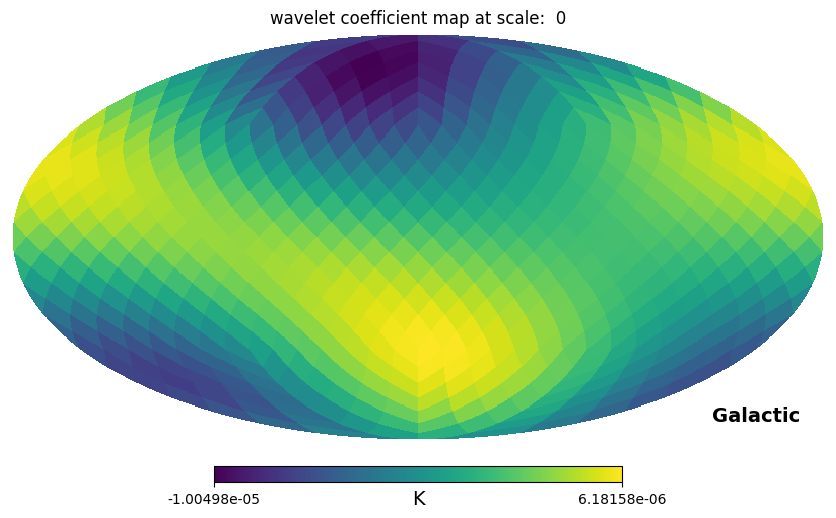

s2sh.forward_torch time: 0.005s


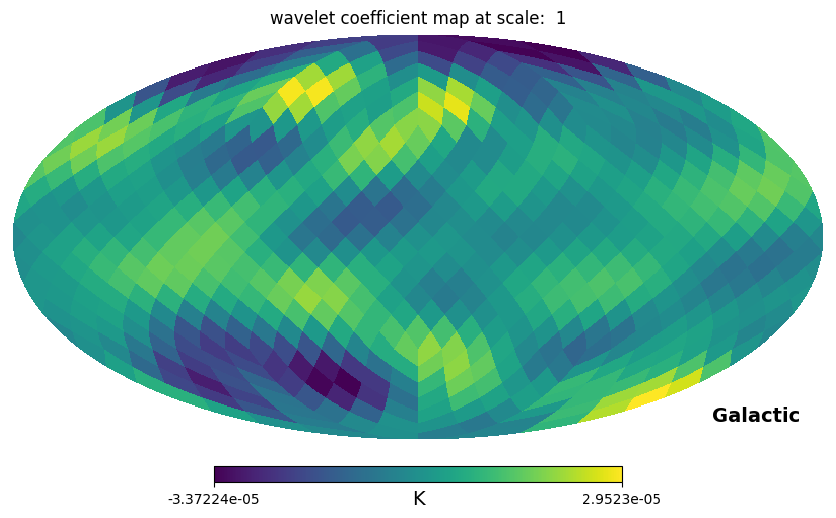

s2sh.forward_torch time: 1.834s


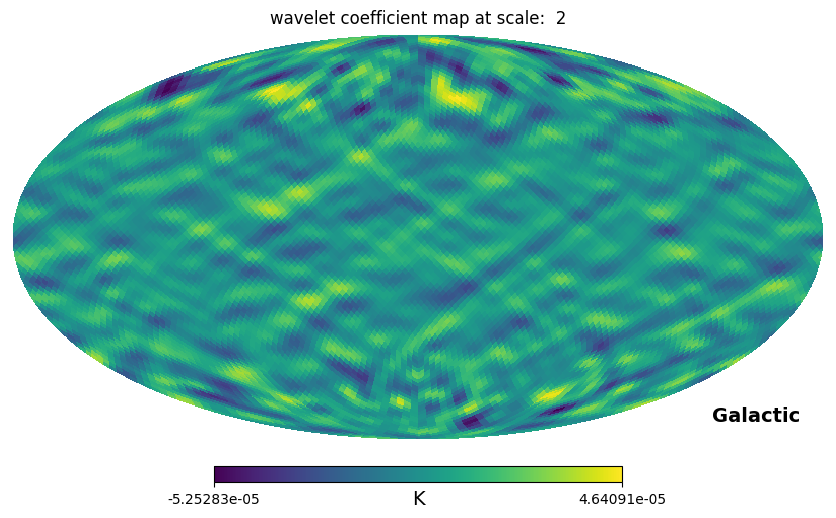

s2sh.forward_torch time: 4.994s


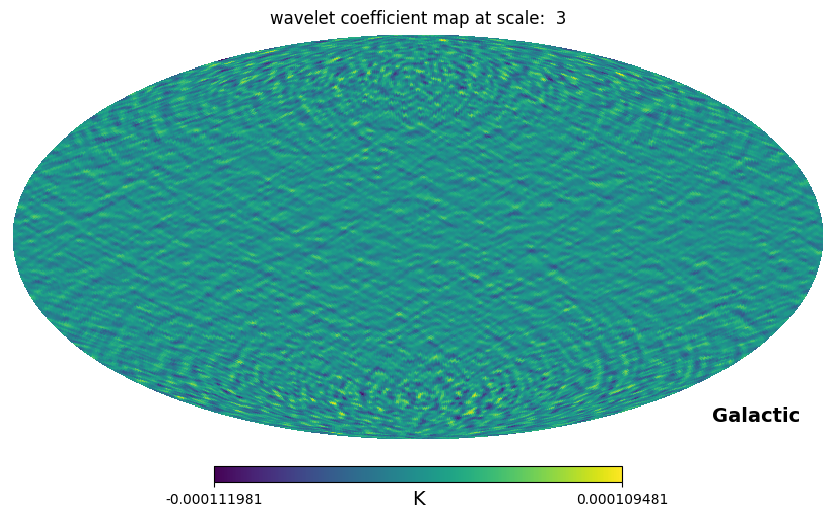

s2sh.forward_torch time: 15.965s


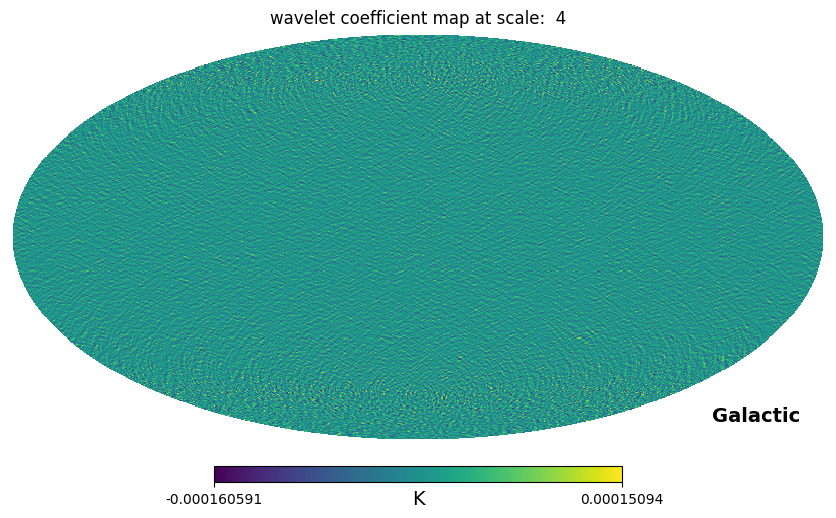

s2sh.forward_torch time: 15.765s


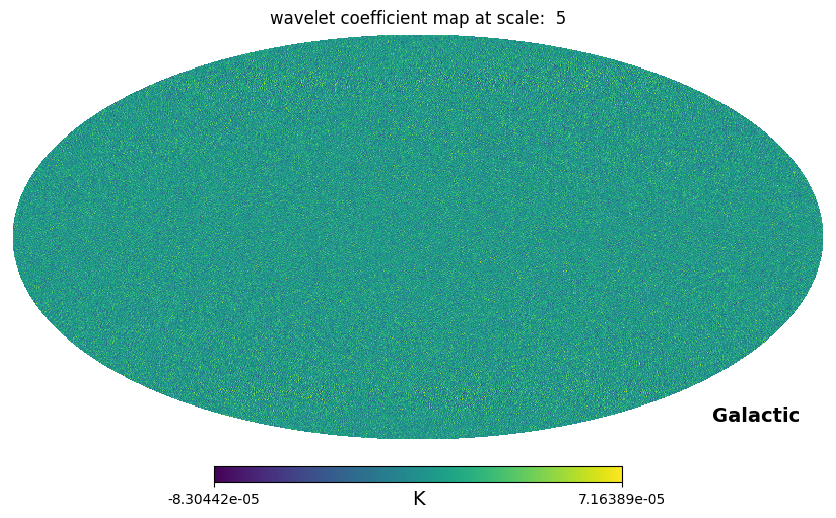

In [18]:
# Define the base path, file template, frequencies, scales, and realizations
# Base path for the generated wavelet coefficient maps
base_path = "data/wavelet_transform/CSN/wavelets/wav_MW_maps"

# File template for the wavelet coefficient maps
file_template = "Wav_MW_Pix_F{}_S{}_R{}.npy"
#frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
scales = [0, 1, 2, 3, 4, 5]
frequencies = ['030', '100', '353']
realizations = [0]
process_wavelet_maps(base_path, file_template, frequencies, scales, realizations, use_torch = True, visualize = True)


### 4.4 Visualize ILC combined Wavelet coefficient maps for each scale

In [ ]:
# L max for the wavelet coefficient map
L_max = 32
N_directions = 1

for i in range(1):
    realization = str(realizations[i]).zfill(4)
    trimmed_maps = [np.load(f"ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{i}_R{realization}.npy") for i in range(len(scales))]
    for j in range(len(scales)):
            visualize_wavelet_coefficient_map(trimmed_maps[j], "ILC wavelet coefficient map at scale: ", str(j))

### 4.5 Synthesize ILC wavelet coefficient maps of all scales together. 
Note: Unfinished task for handling scaling coefficient.

In [10]:
import s2wav
from s2wav import filters
L_max = 1024
lam = 4
N_directions = 1
realizations = [0]
scales = [0, 1, 2, 3, 4, 5]
frequencies = ['030', '100', '353']
for i in range(len(realizations)):
    realization = str(realizations[i]).zfill(4)
    ILC_trimmed_wav_maps = [np.load(f"data/ILC/ILC_processed_wavelet_maps/ILC_processed_wav_Map_S{scale}_R{realization}.npy") for scale in range(len(scales))]

    filter = filters.filters_directional_vectorised(L_max, N_directions, lam = lam)
    # f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
    f_scal = np.array([[0]])    
    # [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

    MW_Pix = s2wav.synthesis(ILC_trimmed_wav_maps, L = L_max, f_scal = f_scal, lam = lam, filters = filter, N = 1)
    title = "ILC CMB Map realization: "
    visualize_wavelet_coefficient_map(MW_Pix, title, str(realizations[i]))
    np.save(f"data/ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realization}", MW_Pix)

TypeError: the read only flag is not supported, should always be False